In [10]:
import pennylane as qml

import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler

Generate the shadow with the pennylane library (maybe I am doing it wrong with qiskit)

In [11]:
def calculate_classical_shadow(circuit_template, params, shadow_size, num_qubits):
    """
    Given a circuit, creates a collection of snapshots consisting of a bit string
    and the index of a unitary operation.

    Args:
        circuit_template (function): A Pennylane QNode.
        params (array): Circuit parameters.
        shadow_size (int): The number of snapshots in the shadow.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        Tuple of two numpy arrays. The first array contains measurement outcomes (-1, 1)
        while the second array contains the index for the sampled Pauli's (0,1,2=X,Y,Z).
        Each row of the arrays corresponds to a distinct snapshot or sample while each
        column corresponds to a different qubit.
    """
    # applying the single-qubit Clifford circuit is equivalent to measuring a Pauli
    unitary_ensemble = [qml.PauliX, qml.PauliY, qml.PauliZ]

    # sample random Pauli measurements uniformly, where 0,1,2 = X,Y,Z
    unitary_ids = np.random.randint(0, 3, size=(shadow_size, num_qubits))
    outcomes = np.zeros((shadow_size, num_qubits))

    for ns in range(shadow_size):
        # for each snapshot, add a random Pauli observable at each location
        obs = [unitary_ensemble[int(unitary_ids[ns, i])](i) for i in range(num_qubits)]
        outcomes[ns, :] = circuit_template(params, observable=obs)

    # combine the computational basis outcomes and the sampled unitaries
    return (outcomes, unitary_ids)

Example: Reconstructing a Bell State
====================================

First, we construct a single-shot, `'lightning.qubit'` device and define
the `bell_state_circuit` QNode to construct and measure a Bell state.


In [12]:
num_qubits = 2

dev = qml.device("lightning.qubit", wires=num_qubits, shots=1)


# circuit to create a Bell state and measure it in
# the bases specified by the 'observable' keyword argument.
@qml.qnode(dev)
def bell_state_circuit(params, **kwargs):
    observables = kwargs.pop("observable")

    return [qml.expval(o) for o in observables]

Then, construct a classical shadow consisting of 1000 snapshots.


In [13]:
num_snapshots = 1000
params = []

shadow = calculate_classical_shadow(
    bell_state_circuit, params, num_snapshots, num_qubits
)
print(shadow[0])
print(shadow[1])

[[ 1.  1.]
 [-1.  1.]
 [ 1.  1.]
 ...
 [ 1.  1.]
 [ 1.  1.]
 [-1.  1.]]
[[2 0]
 [0 2]
 [0 2]
 ...
 [2 1]
 [2 2]
 [1 1]]


In [14]:
def construct_shadow_pennylane(circuit, shadow_size, num_qubits):
    """
    Adapted from https://pennylane.ai/qml/demos/tutorial_classical_shadows/
    Given a quantum circuit, this function creates a collection of bitstrings generated by random single-qubit Pauli measurements and records the associated random pauli measurment.

    Args:
        circuit (QuantumCircuit): The quantum circuit which resulting state we wish to estimate.
        shadow_size (int): The number of random Pauli measurements to be taken.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        np.array: An array of shape (shadow_size, num_qubits) where each element is a tuple of the form (b, unitary_index) where b is the measured basis state in the computational basis and unitary_index is the index of the Pauli operator applied to the qubit.
    """

    # Arrays to store the classical shadow data.
    unitary_ids = np.zeros((shadow_size, num_qubits), dtype=int)
    outcomes = np.zeros((shadow_size, num_qubits), dtype=int)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Create a quantum and classical registers for the circuit.
    qr = QuantumRegister(num_qubits, 'q')
    cr = ClassicalRegister(1, 'c')

    # Iterate over the number of shadows.
    for i in range(shadow_size):

        # Iterate over all the qubits in the circuit.
        for j in range(num_qubits):

            # Randomly select a unitary from the ensemble.
            unitary_index = np.random.randint(0,3)
            unitary = unitary_ensemble[unitary_index]

            # Apply the unitary to the qubit and measure in the computational basis.

            # The circuit below will apply the unitary to qubit j and measure it in the computational basis.
            qc = QuantumCircuit(qr, cr)
            qc.append(UnitaryGate(unitary, "Rand_Pauli"), [j])
            qc.measure(j, 0)

            # Compose the measurment circuit with the input circuit.
            qc = circuit.compose(qc)

            # Instantiate a sampler that runs the cicuit once.
            sampler = StatevectorSampler(default_shots = 1)     
            # Run the sampler on the quantum circuit and store the result.
            result = sampler.run([qc]).result()[0]              

            # Store the counts for number of 0's and 1's measured in the computational basis.
            counts = result.data.c.get_counts()       

            # Get the measured basis state.
            if '0' in counts.keys():
                b = 0
            else:
                b = 1

            # Record the result of the measurement and the unitary applied.
            outcomes[i,j] = b
            unitary_ids[i,j] = unitary_index

    return outcomes, unitary_ids

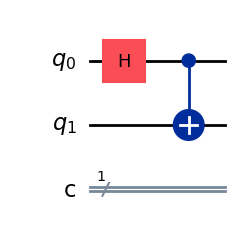

In [15]:
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate quantum register of 2 bits and classical register of 1 bit.
bell_state_qr = QuantumRegister (2, 'q')
bell_state_cr = ClassicalRegister(1, 'c')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr, bell_state_cr)
bell_state_qc.append(
    HGate(),
    [0]
)
bell_state_qc.append(
    CXGate(),
    [0, 1]
)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [16]:
shadow = calculate_classical_shadow(bell_state_qc, 1000, 2)
print(shadow[0])
print(shadow[1])

TypeError: calculate_classical_shadow() missing 1 required positional argument: 'num_qubits'

In [ ]:
def snapshot_state(b_list, obs_list):
    
    num_qubits = len(b_list)

    zero_state = np.array([[1, 0],[0, 0]])
    one_state = np.array([[0, 0],[0, 1]])

    # Local qubit unitaries. 
    phase_z = np.array([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.array([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.array([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    rho_snapshot = [1]
    for i in range(num_qubits):
        state = zero_state if b_list[i] == 0 else one_state
        U = unitary_ensemble[obs_list[i]]

        local_rho = 3*(U.conj().T @ state @ U) - identity
        rho_snapshot = np.kron(rho_snapshot, local_rho)

    return rho_snapshot

def shadow_state_reconstruction(shadow):

    num_snapshots, num_qubits = shadow[0].shape

    b_list, obs_list = shadow

    shadow_rho = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)
    for i in range(num_snapshots):
        shadow_rho += snapshot_state(b_list[i], obs_list[i])

    return shadow_rho/num_snapshots

In [17]:
shadow_state = shadow_state_reconstruction(shadow)
print(np.round(shadow_state, decimals=4))

NameError: name 'shadow_state_reconstruction' is not defined

Something is wrong with this too....